In [2]:
!pip install pytorch_metric_learning
!pip install faiss-cpu
!pip install pytorch-lightning
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=030730887706df1acc12396f12752811de3995bb1bfb4229fd262f0ed763174c
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:
import os
import cv2
import random
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_metric_learning import losses, miners
import faiss
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
BASE_PATH = '/content/drive/MyDrive/cars'
ADD_PATH = os.path.join(BASE_PATH, 'cars_train', 'cars_train')
DEVKIT_PATH = os.path.join(BASE_PATH, 'devkit')

In [142]:
mat = scipy.io.loadmat(f'{DEVKIT_PATH}/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip(
    [i[0] for i in mat['annotations'][0]['fname']],
    [i[0][0] for i in mat['annotations'][0]['class']]
)}

cars_meta = scipy.io.loadmat(f'{DEVKIT_PATH}/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}


Реализовать метрики: Precision@k, Recall@k, mAP

In [143]:
def precision_at_k(true_label, predicted_labels, k):
    if len(predicted_labels) > k:
        predicted_labels = predicted_labels[:k]
    correct = sum([1 for label in predicted_labels if label == true_label])
    return correct / k

def recall_at_k(true_label, predicted_labels, k, total_relevant=None):
    if len(predicted_labels) > k:
        predicted_labels = predicted_labels[:k]
    correct = sum([1 for label in predicted_labels if label == true_label])
    if total_relevant is None:
        total_relevant = k
    return correct / total_relevant

def average_precision(true_label, predicted_labels):
    precisions = []
    num_correct = 0
    for k, pred_label in enumerate(predicted_labels, 1):
        if pred_label == true_label:
            num_correct += 1
            precisions.append(num_correct / k)
    if len(precisions) == 0:
        return 0.0
    return sum(precisions) / len(precisions)

def mean_average_precision(true_labels, all_predicted_labels):
    aps = [average_precision(tl, pl) for tl, pl in zip(true_labels, all_predicted_labels)]
    return np.mean(aps)

def calculate_metrics(true_labels, all_predicted_labels, k_values=[1, 5, 10]):
    metrics = {}
    for k in k_values:
        precisions = [precision_at_k(tl, pl, k) for tl, pl in zip(true_labels, all_predicted_labels)]
        recalls = [recall_at_k(tl, pl, k) for tl, pl in zip(true_labels, all_predicted_labels)]
        metrics[f'Precision@{k}'] = np.mean(precisions)
        metrics[f'Recall@{k}'] = np.mean(recalls)
    metrics['mAP'] = mean_average_precision(true_labels, all_predicted_labels)
    return metrics

Добавить train аугментации

In [144]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [145]:
class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms, images_path):
        self.cars = cars_items
        self.transforms = transforms
        self.images_path = images_path

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image_path = os.path.join(self.images_path, filename)

        if not os.path.exists(image_path):
            raise ValueError(f"Cannot find image: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot read image: {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        return {'image': image, 'label': cl_id}

In [146]:
items = list(fname_to_class.items())
random.seed(42)
random.shuffle(items)

In [147]:
subset_size = int(len(items) * 1) # до этого брала часть
items = items[:subset_size]
print(f"Используем {subset_size} изображений из {len(fname_to_class)} (50% датасета)")

train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

print(f"Train: {len(train_items)} изображений")
print(f"Val: {len(val_items)} изображений")

Используем 8144 изображений из 8144 (50% датасета)
Train: 6515 изображений
Val: 1629 изображений


In [148]:
train_dataset = CropClassifDataset(train_items, train_transforms, ADD_PATH)
val_dataset = CropClassifDataset(val_items, val_transforms, ADD_PATH)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         num_workers=2, pin_memory=True)

MobileNetV2 и Triplet Loss

In [171]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, num_classes, lr, embedding_size=512):
        super().__init__()
        self.lr = lr
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.save_hyperparameters()

        self.backbone = torchvision.models.mobilenet_v2(pretrained=True)

        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False

        num_features = self.backbone.classifier[1].in_features

        self.features = self.backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_features, embedding_size)
        )

        self.backbone.classifier = self.classifier

        self.triplet_loss = losses.TripletMarginLoss(margin=0.2)
        self.miner = miners.MultiSimilarityMiner(epsilon=0.1)

        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        embeddings = self.classifier(x)
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings

    def get_feature_maps(self, x):
        return self.features(x)

    def get_target_layers(self):
        return [self.features[-1]]

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.triplet_loss(embeddings, labels, hard_pairs)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.training_step_outputs.append(loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.triplet_loss(embeddings, labels, hard_pairs)
        self.log('validation_loss', loss, on_epoch=True, prog_bar=True)
        self.validation_step_outputs.append({'loss': loss, 'embeddings': embeddings, 'labels': labels})
        return loss

    def on_train_epoch_end(self):
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'validation_loss'}
        }

In [172]:
pl_model = CarEmbedder(num_classes=len(id_to_car), lr=3e-4, embedding_size=512)

In [173]:
checkpoint_callback = ModelCheckpoint(
    monitor='validation_loss',
    mode='min',
    save_top_k=1,
    filename='car-embedder-{epoch:02d}-{validation_loss:.2f}',
    verbose=True
)
early_stopping = EarlyStopping(
    monitor="validation_loss",
    mode="min",
    patience=3,
    verbose=True
)
lr_monitor = LearningRateMonitor(logging_interval='step')

Обучить модель

In [174]:
trainer = pl.Trainer(
    max_epochs=15,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    log_every_n_steps=5,
    enable_progress_bar=True,
    enable_model_summary=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [175]:
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(valid_loader)}")

try:
    trainer.fit(pl_model, train_loader, valid_loader)
    print("Обучение завершено")
except Exception as e:
    print(f"Ошибка {e}")
    import traceback
    traceback.print_exc()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                 | Params | Mode 
--------------------------------------------------------------
0 | backbone     | MobileNetV2          | 2.9 M  | train
1 | features     | Sequential           | 2.2 M  | train
2 | avgpool      | AdaptiveAvgPool2d    | 0      | train
3 | classifier   | Sequential           | 655 K  | train
4 | triplet_loss | TripletMarginLoss    | 0      | train
5 | miner        | MultiSimilarityMiner | 0      | train
--------------------------------------------------------------
1.7 M     Trainable params
1.2 M     Non-trainable params
2.9 M     Total params
11.519    Total estimated model params size (MB)
219       Modules in train mode
0         Modules in eval mode


Train batches: 101
Val batches: 26


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved. New best score: 0.207
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 101: 'validation_loss' reached 0.20724 (best 0.20724), saving model to '/content/lightning_logs/version_17/checkpoints/car-embedder-epoch=00-validation_loss=0.21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 202: 'validation_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.203
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 303: 'validation_loss' reached 0.20262 (best 0.20262), saving model to '/content/lightning_logs/version_17/checkpoints/car-embedder-epoch=02-validation_loss=0.20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.190
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 404: 'validation_loss' reached 0.18954 (best 0.18954), saving model to '/content/lightning_logs/version_17/checkpoints/car-embedder-epoch=03-validation_loss=0.19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 505: 'validation_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 606: 'validation_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric validation_loss did not improve in the last 3 records. Best score: 0.190. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 707: 'validation_loss' was not in top 1


Обучение завершено


Рассчитать метрики из п.1

In [177]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            batch_labels = batch['label']

            emb = model(images)
            embeddings.append(emb.cpu().numpy())
            labels.extend(batch_labels.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    return embeddings, labels

In [178]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_emb, train_labels = extract_embeddings(pl_model, train_loader, device)
val_emb, val_labels = extract_embeddings(pl_model, valid_loader, device)

In [179]:
embedding_dim = train_emb.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(train_emb.astype('float32'))

print(f"Total vectors in index: {index.ntotal}")

Total vectors in index: 6464


In [180]:
k = 10
D, I = index.search(val_emb.astype('float32'), k)

predicted_labels_list = [train_labels[indices].tolist() for indices in I]

metrics = calculate_metrics(val_labels, predicted_labels_list, k_values=[1, 5, 10])

print("\nМетрики")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")


Метрики
Precision@1: 0.1191
Recall@1: 0.1191
Precision@5: 0.0875
Recall@5: 0.0875
Precision@10: 0.0783
Recall@10: 0.0783
mAP: 0.1809


Показать с помощью GradCAM, где ошибается модель

In [181]:
wrong_predictions = []
for i, (true_label, pred_labels) in enumerate(zip(val_labels, predicted_labels_list)):
    if pred_labels[0] != true_label:
        wrong_predictions.append((i, true_label, pred_labels[0]))

print(f"\n Найдено {len(wrong_predictions)} ошибочных предсказаний")


 Найдено 1435 ошибочных предсказаний


In [202]:
def simple_gradcam_for_error(model, val_dataset, error_idx, device):
    try:
        model.eval()

        sample = val_dataset[error_idx]
        image = sample['image'].unsqueeze(0).to(device)
        true_label = sample['label']

        filename, _ = val_dataset.cars[error_idx]
        img_path = os.path.join(ADD_PATH, filename)

        orig_img = cv2.imread(img_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_img = cv2.resize(orig_img, (224, 224))
        orig_img_normalized = orig_img.astype(np.float32) / 255.0

        with torch.no_grad():
            feature_maps = model.get_feature_maps(image)

        heatmap = torch.mean(feature_maps, dim=1).squeeze()
        heatmap = torch.nn.functional.relu(heatmap)
        heatmap = heatmap.cpu().numpy()

        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)

        heatmap = cv2.resize(heatmap, (224, 224))

        cam_image = show_cam_on_image(orig_img_normalized, heatmap, use_rgb=True)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title(f'Истинный класс: {id_to_car.get(true_label, "Unknown")}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.title('GradCAM (по активациям)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка: {e}")


GRADCAM - анализ ошибок

Ошибка #1:
Истинный класс: Hyundai Santa Fe SUV 2012
Предсказанный класс: Dodge Journey SUV 2012


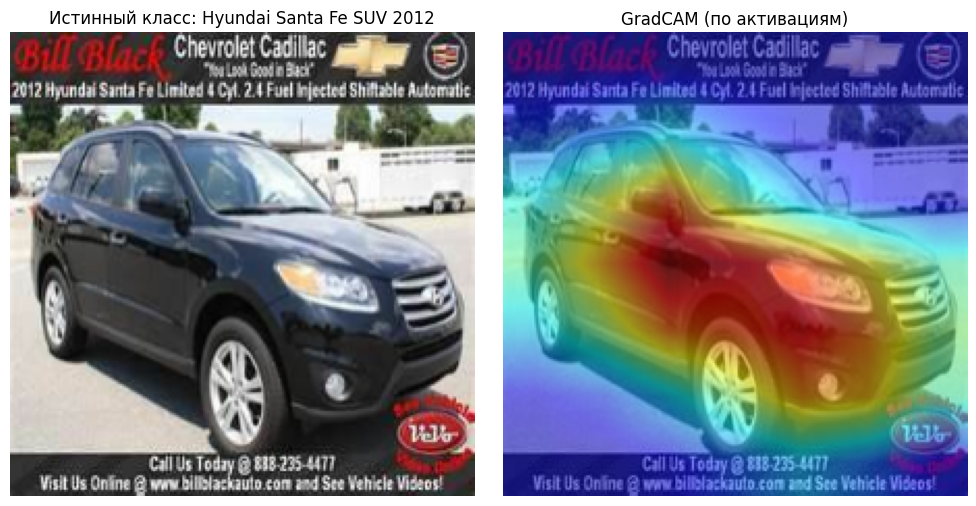


Ошибка #2:
Истинный класс: Ram C/V Cargo Van Minivan 2012
Предсказанный класс: Honda Odyssey Minivan 2012


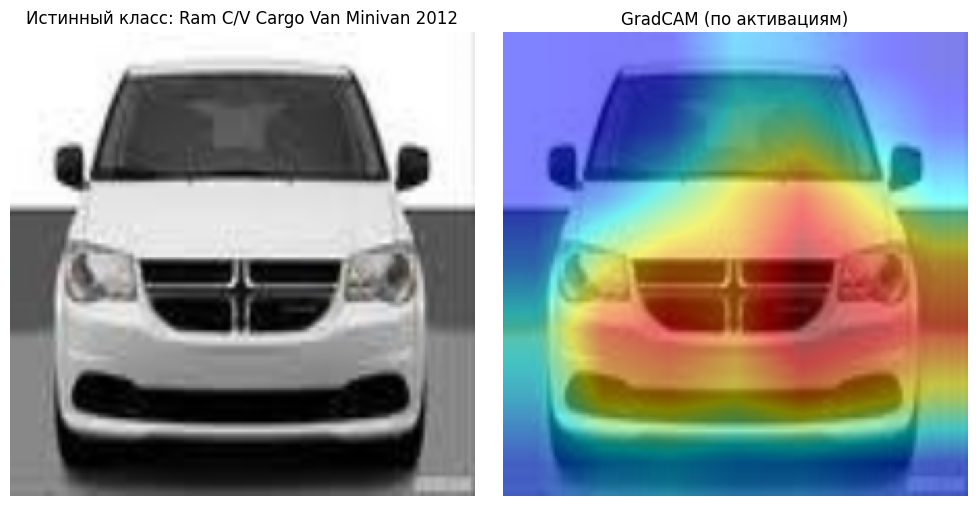


Ошибка #3:
Истинный класс: Ford Edge SUV 2012
Предсказанный класс: Land Rover LR2 SUV 2012


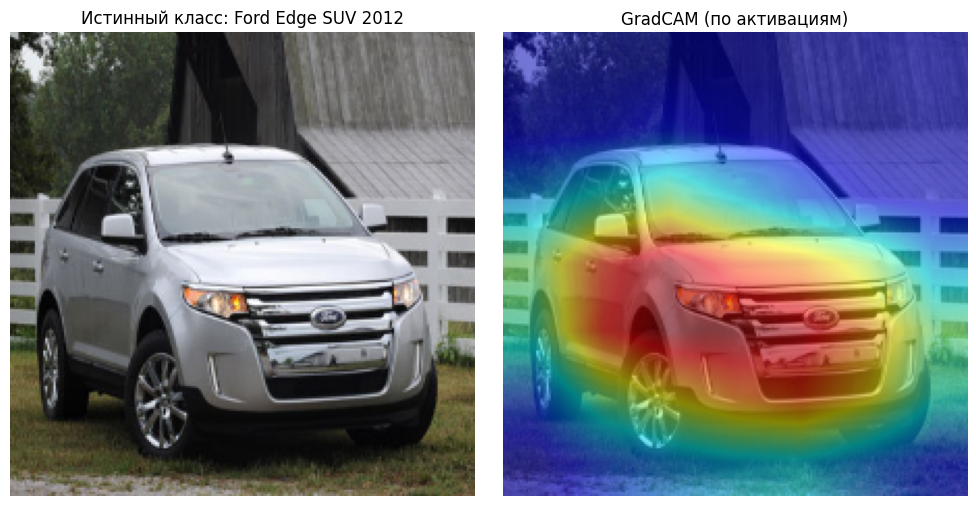

In [201]:
print("\nGRADCAM - анализ ошибок")

for i in range(min(3, len(wrong_predictions))):
    error_idx, true_label, pred_label = wrong_predictions[i]
    print(f"\nОшибка #{i+1}:")
    print(f"Истинный класс: {id_to_car[true_label]}")
    print(f"Предсказанный класс: {id_to_car[pred_label]}")

    simple_gradcam_for_error(pl_model, val_dataset, error_idx, device)